In [1]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
import timm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score
from utils.utils import get_device, set_seed

## 設定

In [2]:
pattern_date = '2023-12-24'
root_dir = f'{"/".join(os.getcwd().split("/")[:-1])}'
pose_output_dir = f'{root_dir}/data/outputs/02.pose_estimation'
head_detection_label_dir = f'{root_dir}/data/outputs/03.helmet_detection/00.head_detection_add_label'
train_result_dir = f'{root_dir}/data/outputs/03.helmet_detection/02.training_coatnet_cls7_use_anno'
result_dir = f'{root_dir}/data/outputs/03.helmet_detection/03.eval_coatnet_cls7_use_anno'

In [3]:
annotation_head_df = pd.read_csv(f'{pose_output_dir}/head_eval_annotation-{pattern_date}.csv')
pred_head_df = pd.read_csv(f'{head_detection_label_dir}/head_eval_pred_add_label-{pattern_date}.csv')

In [4]:
class_category = [
    ['detection-miss'],
    ['helmet'],
    ['helmet unknown (occlusion)'],
    ['helmet unknown (small)'],
    ['unsafe-helmet (inadequate covering)'],
    ['unsafe-helmet (no chin strap)'],
    ['no-helmet'],
]
no_alarm_class_category = ['detection-miss', 'helmet', 'helmet unknown (occlusion)', 'helmet unknown (small)']

In [5]:
huggingface_model_name = 'coatnet_2_rw_224.sw_in12k_ft_in1k'
input_img_size = 224

In [6]:
# パラメータ
batch_size = 32
seed = 42

## ヘルメット分類の推論実行

In [7]:
set_seed(seed=seed)
device = get_device()

In [8]:
class ClassificationDataset(Dataset):
    def __init__(self, df, transform=None, training=False):
        self.df = df
        self.img_paths = [f'{root_dir}/data/images/{path}' for path in df['relative_img_path'].values]
        self.labels = list(df['label'].values)
        self.bboxes = list(df[['left', 'top', 'right', 'bottom']].values)
        self.transform = transform
        self.training = training

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx])
        bbox = self.bboxes[idx]
        if self.training:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            img_width, img_height = image.size

            random_ratio = random.uniform(0, 0.2)
            add_bbox_width = bbox_width * random_ratio
            add_bbox_height = bbox_height * random_ratio
            bbox[0] = bbox[0] - add_bbox_width / 2 if bbox[0] - add_bbox_width / 2 > 0 else 0
            bbox[1] = bbox[1] - add_bbox_height / 2 if bbox[1] - add_bbox_height / 2 > 0 else 0
            bbox[2] = bbox[2] + add_bbox_width / 2 if bbox[2] + add_bbox_width / 2 < img_width else img_width
            bbox[3] = bbox[3] + add_bbox_height / 2 if bbox[3] + add_bbox_height / 2 < img_height else img_height

            cropped_image = image.crop(bbox)
        else:
            cropped_image = image.crop(bbox)

        img = np.array(cropped_image)
        augmented = self.transform(image=img)
        image = augmented['image']

        for i, category_names in enumerate(class_category):
            if self.labels[idx] in category_names:
                label = i
        return image, label

    def __len__(self):
        return len(self.df)

In [9]:
A_transforms_val = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

### cross-validationでの評価

In [10]:
labels_list = []
prob_list = []
valid_all_df_list = []
for num_cv in range(3):
    valid_df = pred_head_df[
        (pred_head_df['validation'] == num_cv) &
        (
            (pred_head_df['unique_key'].str.contains('fixed-point-camera')) |
            (pred_head_df['unique_key'].str.contains('for-learning/2023-11-19-omaezaki-500')) |
            (pred_head_df['unique_key'].str.contains('for-learning/2023-11-23-mie-safetybelt'))
        )
    ]
    valid_all_df_list.append(valid_df)

    valid_data = ClassificationDataset(valid_df, A_transforms_val)
    valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False)

    # model
    model = timm.create_model(huggingface_model_name, pretrained=True, num_classes=len(class_category))
    model.load_state_dict(torch.load(f'{train_result_dir}/{num_cv}/model.pth'))
    model.to(device)

    with torch.no_grad():
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            probs = F.softmax(val_output, dim=1)
            labels_list.append(label.detach().cpu().numpy())
            prob_list.append(probs.detach().cpu().numpy())
labels_np = np.concatenate(labels_list)
prob_np = np.concatenate(prob_list)
prob_argmax = np.argmax(prob_np, axis=1)
valid_all_df = pd.concat(valid_all_df_list)

/home/kicodevs/.local/share/virtualenvs/crassone-analysis-IVAO5Hrn/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

#### confusion matrix - 確率値が最大のクラスをそのまま予測クラスにする

In [11]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, prob in zip(labels_np, prob_argmax):
    confusion_mat[label][prob] += 1
display(pd.DataFrame(
    confusion_mat, index=[i[0] for i in class_category], columns=[i[0] for i in class_category]
))

,detection-miss,helmet,helmet unknown (occlusion),helmet unknown (small),unsafe-helmet (inadequate covering),unsafe-helmet (no chin strap),no-helmet
detection-miss,236,1,25,32,50,3,15
helmet,2,86,5,19,27,61,0
helmet unknown (occlusion),22,12,116,39,54,17,1
helmet unknown (small),4,5,15,66,19,11,0
unsafe-helmet (inadequate covering),18,8,16,25,425,19,0
unsafe-helmet (no chin strap),5,36,4,25,23,214,1
no-helmet,15,0,1,1,16,6,204


#### confusion matrix - 閾値をprecision@0.95にして予測クラスにする

In [12]:
def pred_class_names_precision095(row):
    unsafe_inadequate_covering_threshold = row['threshold - unsafe-helmet (inadequate covering)']
    unsafe_no_chin_strap_threshold = row['threshold - unsafe-helmet (no chin strap)']
    no_helmet_threshold = row['threshold - no-helmet']
    pred_class = []
    if row['unsafe-helmet (inadequate covering)'] >= unsafe_inadequate_covering_threshold:
        pred_class.append('unsafe-helmet (inadequate covering)')
    if row['unsafe-helmet (no chin strap)'] >= unsafe_no_chin_strap_threshold:
        pred_class.append('unsafe-helmet (no chin strap)')
    if row['no-helmet'] >= no_helmet_threshold:
        pred_class.append('no-helmet')
    if len(pred_class) > 0:
        return row[pred_class].idxmax()
    return row[[i[0] for i in class_category[0:4]]].idxmax()

In [13]:
# calculate precision@0.95 threshold
threshold_precision095_df_list = []
for num_cv in range(3):
    threshold_precision095_valid_dict = {}
    for class_num, class_names in enumerate(class_category):
        if any([no_alarm_class in class_names for no_alarm_class in no_alarm_class_category]):
            continue
        tmp_use_label = [label for label, valid in zip(labels_np, list(valid_all_df['validation'])) if valid == num_cv]
        tmp_use_prob = [prob for prob, valid in zip(prob_np, list(valid_all_df['validation'])) if valid == num_cv]
        use_label = [i for i in tmp_use_label if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_prob = [j for i, j in zip(tmp_use_label, tmp_use_prob) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
        use_prob = np.array([i[class_num] for i in use_prob])
        precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
        _threshold = 1.0
        for p, t in zip(precisions, thresholds):
            if p >= 0.95:
                _threshold = t
                break
        threshold_precision095_valid_dict[class_names[0]] = _threshold
    threshold_precision095_df_list.append(pd.DataFrame(
        [[i for i in threshold_precision095_valid_dict.values()] for _ in range(len(valid_all_df[valid_all_df['validation'] == num_cv]))],
        columns=[f'threshold - {i}' for i in threshold_precision095_valid_dict.keys()]
    ))
threshold_precision095_df = pd.concat(threshold_precision095_df_list).reset_index(drop=True)
prob_df = pd.concat([pd.DataFrame(prob_np, columns=[i[0] for i in class_category]), threshold_precision095_df], axis=1)

In [14]:
valid_all_df['pred_head_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))

In [15]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, pred_name in zip(labels_np, list(valid_all_df['pred_head_class'])):
    pred_num = [i for i, class_names in enumerate(class_category) if pred_name in class_names][0]
    confusion_mat[label][pred_num] += 1
display(pd.DataFrame(
    confusion_mat, index=[i[0] for i in class_category], columns=[i[0] for i in class_category]
))

,detection-miss,helmet,helmet unknown (occlusion),helmet unknown (small),unsafe-helmet (inadequate covering),unsafe-helmet (no chin strap),no-helmet
detection-miss,268,6,38,38,4,0,8
helmet,9,154,7,28,0,2,0
helmet unknown (occlusion),35,23,149,48,4,1,1
helmet unknown (small),6,10,25,78,0,1,0
unsafe-helmet (inadequate covering),148,46,109,51,156,1,0
unsafe-helmet (no chin strap),16,123,19,57,0,93,0
no-helmet,30,3,10,7,1,0,192


#### PR-AUC

validation: 0
['unsafe-helmet (inadequate covering)'] - PR-AUC: 0.8607
precision@0.91 - Recall: 0.5605 - Threshold: 0.8169
precision@0.95 - Recall: 0.2484 - Threshold: 0.9887 

['unsafe-helmet (no chin strap)'] - PR-AUC: 0.8654
precision@0.90 - Recall: 0.6535 - Threshold: 0.8521
precision@0.96 - Recall: 0.4554 - Threshold: 0.9433 

['no-helmet'] - PR-AUC: 0.9146
precision@0.90 - Recall: 0.8721 - Threshold: 0.1744
precision@0.95 - Recall: 0.7209 - Threshold: 0.7819 



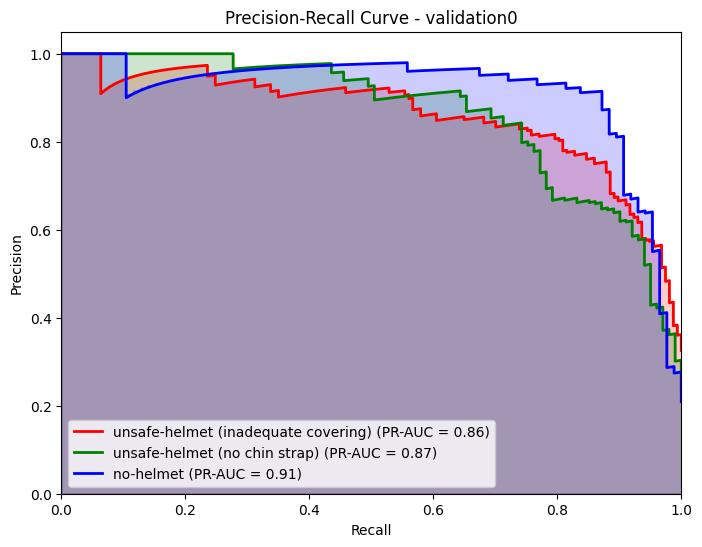

validation: 1
['unsafe-helmet (inadequate covering)'] - PR-AUC: 0.8520
precision@0.90 - Recall: 0.4912 - Threshold: 0.8637
precision@0.95 - Recall: 0.1111 - Threshold: 0.9693 

['unsafe-helmet (no chin strap)'] - PR-AUC: 0.8451
precision@0.91 - Recall: 0.4952 - Threshold: 0.6634
precision@0.96 - Recall: 0.2381 - Threshold: 0.8363 

['no-helmet'] - PR-AUC: 0.9255
precision@0.90 - Recall: 0.9184 - Threshold: 0.2266
precision@0.96 - Recall: 0.8980 - Threshold: 0.3893 



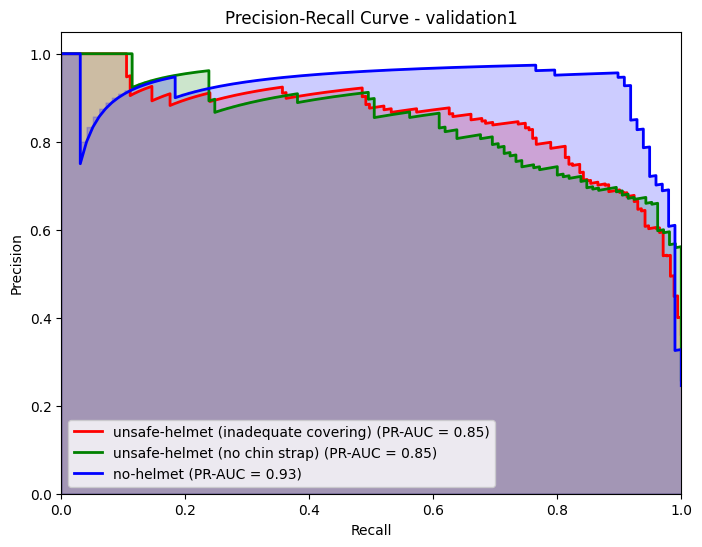

validation: 2
['unsafe-helmet (inadequate covering)'] - PR-AUC: 0.8885
precision@0.91 - Recall: 0.6776 - Threshold: 0.8728
precision@0.95 - Recall: 0.5355 - Threshold: 0.9429 

['unsafe-helmet (no chin strap)'] - PR-AUC: 0.7715
precision@0.92 - Recall: 0.2255 - Threshold: 0.8647
precision@0.96 - Recall: 0.2157 - Threshold: 0.8714 

['no-helmet'] - PR-AUC: 0.9369
precision@0.91 - Recall: 0.8475 - Threshold: 0.4559
precision@0.95 - Recall: 0.7119 - Threshold: 0.8995 



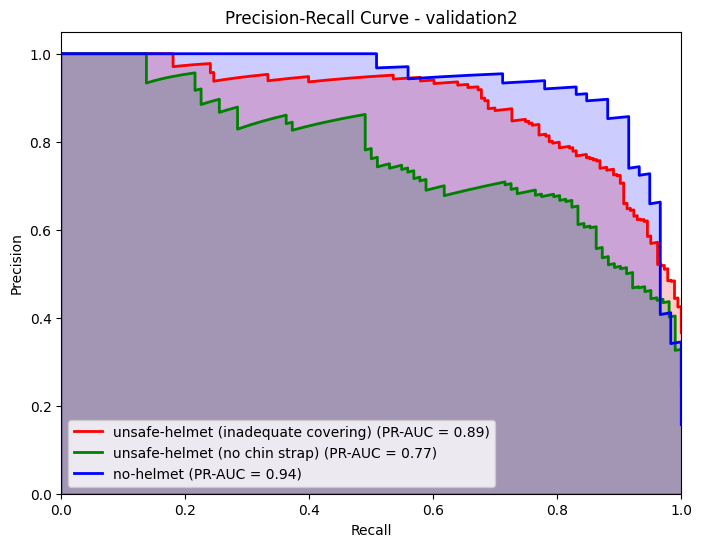

In [16]:
# PR-AUC
average_precision_cv_list = []
result_precision095_cv_list = []

threshold_unsafe_helmet_inadequate_covering_list = []
threshold_unsafe_helmet_no_chin_strap_list = []
threshold_no_helmet_list = []

for num_cv in range(3):
    print(f'validation: {num_cv}')
    plt.figure(figsize=(8, 6))
    average_precision_list = []
    result_precision095_list = []
    for class_num, class_names in enumerate(class_category):
        if any([no_alarm_class in class_names for no_alarm_class in no_alarm_class_category]):
            continue

        tmp_use_label = [label for label, valid in zip(labels_np, list(valid_all_df['validation'])) if valid == num_cv]
        tmp_use_prob = [prob for prob, valid in zip(prob_np, list(valid_all_df['validation'])) if valid == num_cv]
        use_label = [i for i in tmp_use_label if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_prob = [j for i, j in zip(tmp_use_label, tmp_use_prob) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
        use_prob = np.array([i[class_num] for i in use_prob])

        average_precision = average_precision_score(use_label, use_prob)
        precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
        result_precision090 = [0.9, 0, 0] # precision, recall, threshold で保存
        result_precision095 = [0.95, 0, 0] # precision, recall, threshold で保存
        for p, r, t in zip(precisions, recalls, thresholds):
            if p >= 0.9:
                result_precision090 = [p, r, t]
                break
        for p, r, t in zip(precisions, recalls, thresholds):
            if p >= 0.95:
                result_precision095 = [p, r, t]
                break

        average_precision_list.append(average_precision)
        result_precision095_list.append(result_precision095)

        print(f'{class_names} - PR-AUC: {average_precision:.4f}')
        print(f'precision@{result_precision090[0]:.2f} - Recall: {result_precision090[1]:.4f} - Threshold: {result_precision090[2]:.4f}')
        print(f'precision@{result_precision095[0]:.2f} - Recall: {result_precision095[1]:.4f} - Threshold: {result_precision095[2]:.4f} \n')
        if 'unsafe-helmet (inadequate covering)' in class_names:
            color = 'r'
            threshold_unsafe_helmet_inadequate_covering_list += [result_precision095[2]]
        elif 'unsafe-helmet (no chin strap)' in class_names:
            color = 'g'
            threshold_unsafe_helmet_no_chin_strap_list += [result_precision095[2]]
        elif 'no-helmet' in class_names:
            color = 'b'
            threshold_no_helmet_list += [result_precision095[2]]
        plt.plot(recalls, precisions, color=color, lw=2, label=f'{class_names[0]} (PR-AUC = {average_precision:.2f})')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve - validation{num_cv}')
    plt.legend(loc='best')
    plt.show()

    average_precision_cv_list.append(average_precision_list)
    result_precision095_cv_list.append(result_precision095_list)

In [17]:
threshold_unsafe_helmet_inadequate_covering_mean = sum(threshold_unsafe_helmet_inadequate_covering_list) / 3.0
threshold_unsafe_helmet_no_chin_strap_mean = sum(threshold_unsafe_helmet_no_chin_strap_list) / 3.0
threshold_no_helmet_mean = sum(threshold_no_helmet_list) / 3.0
print('Threshold')
print(f'unsafe helmet (inadequate covering): {threshold_unsafe_helmet_inadequate_covering_mean}')
print(f'unsafe helmet (no chin strap): {threshold_unsafe_helmet_no_chin_strap_mean}')
print(f'no helmet: {threshold_no_helmet_mean}')

Threshold
unsafe helmet (inadequate covering): 0.9669731458028158
unsafe helmet (no chin strap): 0.883650521437327
no helmet: 0.6902465720971426


In [18]:
unsafe_helmet_inadequate_covering_cv_weight = []
unsafe_helmet_no_chin_strap_cv_weight = []
no_helmet_cv_weight = []
for num_cv in range(3):
    _valid_all_df = valid_all_df[valid_all_df['validation'] == num_cv]
    for category in ['unsafe-helmet (inadequate covering)', 'unsafe-helmet (no chin strap)', 'no-helmet']:
        _tmp_df = _valid_all_df[
            (_valid_all_df['label'] == category) |
            (_valid_all_df['label'] == 'detection-miss') |
            (_valid_all_df['label'] == 'helmet') |
            (_valid_all_df['label'] == 'helmet unknown (occlusion)') |
            (_valid_all_df['label'] == 'helmet unknown (small)')
        ]
        if category == 'unsafe-helmet (inadequate covering)':
            unsafe_helmet_inadequate_covering_cv_weight.append(len(_tmp_df))
        if category == 'unsafe-helmet (no chin strap)':
            unsafe_helmet_no_chin_strap_cv_weight.append(len(_tmp_df))
        if category == 'no-helmet':
            no_helmet_cv_weight.append(len(_tmp_df))

In [19]:
average_precision_unsafe_helmet_inadequate_covering = sum(
    [
        ap[0] * weight / sum(unsafe_helmet_inadequate_covering_cv_weight)
        for ap, weight in zip(average_precision_cv_list, unsafe_helmet_inadequate_covering_cv_weight)
    ]
)
print(f'PR-AUC - unsafe helmet (inadequate covering): {average_precision_unsafe_helmet_inadequate_covering}')
average_precision_unsafe_helmet_no_chin_strap = sum(
    [
        ap[1] * weight / sum(unsafe_helmet_no_chin_strap_cv_weight)
        for ap, weight in zip(average_precision_cv_list, unsafe_helmet_no_chin_strap_cv_weight)
    ]
)
print(f'PR-AUC - unsafe helmet (no chin strap): {average_precision_unsafe_helmet_no_chin_strap}')
average_precision_no_helmet = sum(
    [
        ap[2] * weight / sum(no_helmet_cv_weight)
        for ap, weight in zip(average_precision_cv_list, no_helmet_cv_weight)
    ]
)
print(f'PR-AUC - no helmet: {average_precision_no_helmet}')

PR-AUC - unsafe helmet (inadequate covering): 0.8674233439230478
PR-AUC - unsafe helmet (no chin strap): 0.8273533141526077
PR-AUC - no helmet: 0.9253296149487459


In [20]:
recall_unsafe_helmet_inadequate_covering = sum(
    [
        re[0][1] * weight / sum(unsafe_helmet_inadequate_covering_cv_weight)
        for re, weight in zip(result_precision095_cv_list, unsafe_helmet_inadequate_covering_cv_weight)
    ]
)
print(f'Recall - unsafe helmet (inadequate covering): {recall_unsafe_helmet_inadequate_covering}')
recall_precision_unsafe_helmet_no_chin_strap = sum(
    [
        re[1][1] * weight / sum(unsafe_helmet_no_chin_strap_cv_weight)
        for re, weight in zip(result_precision095_cv_list, unsafe_helmet_no_chin_strap_cv_weight)
    ]
)
print(f'Recall - unsafe helmet (no chin strap): {recall_precision_unsafe_helmet_no_chin_strap}')
recall_precision_no_helmet = sum(
    [
        re[2][1] * weight / sum(no_helmet_cv_weight)
        for re, weight in zip(result_precision095_cv_list, no_helmet_cv_weight)
    ]
)
print(f'Recall - no helmet: {recall_precision_no_helmet}')

Recall - unsafe helmet (inadequate covering): 0.3025698014872129
Recall - unsafe helmet (no chin strap): 0.3046035313081315
Recall - no helmet: 0.7776130327287202


In [21]:
precision_unsafe_helmet_inadequate_covering = sum(
    [
        re[0][0] * weight / sum(unsafe_helmet_inadequate_covering_cv_weight)
        for re, weight in zip(result_precision095_cv_list, unsafe_helmet_inadequate_covering_cv_weight)
    ]
)
print(f'Precision - unsafe helmet (inadequate covering): {precision_unsafe_helmet_inadequate_covering}')
precision_precision_unsafe_helmet_no_chin_strap = sum(
    [
        re[1][0] * weight / sum(unsafe_helmet_no_chin_strap_cv_weight)
        for re, weight in zip(result_precision095_cv_list, unsafe_helmet_no_chin_strap_cv_weight)
    ]
)
print(f'Precision - unsafe helmet (no chin strap): {precision_precision_unsafe_helmet_no_chin_strap}')
precision_precision_no_helmet = sum(
    [
        re[2][0] * weight / sum(no_helmet_cv_weight)
        for re, weight in zip(result_precision095_cv_list, no_helmet_cv_weight)
    ]
)
print(f'Precision - no helmet: {precision_precision_no_helmet}')

Precision - unsafe helmet (inadequate covering): 0.950905062048043
Precision - unsafe helmet (no chin strap): 0.9587667658515329
Precision - no helmet: 0.9549679882402223


## テストデータで評価

In [22]:
labels_list = []
prob_list = []
test_df = pred_head_df[pred_head_df['validation'] == 999]
test_data = ClassificationDataset(test_df, A_transforms_val)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)

# model
for num_cv in range(3):
    model = timm.create_model(huggingface_model_name, pretrained=True, num_classes=len(class_category))
    model.load_state_dict(torch.load(f'{train_result_dir}/{num_cv}/model.pth'))
    model.to(device)

    with torch.no_grad():
        labels_list_cv = []
        prob_list_cv = []
        for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            probs = F.softmax(val_output, dim=1)
            labels_list_cv.append(label.detach().cpu().numpy())
            prob_list_cv.append(probs.detach().cpu().numpy())
        labels_np_cv = np.concatenate(labels_list_cv)
        prob_np_cv = np.concatenate(prob_list_cv)
        labels_list.append(labels_np_cv)
        prob_list.append(prob_np_cv)

labels_np = labels_list[0]
prob_np = (prob_list[0] + prob_list[1] + prob_list[2]) / 3
prob_argmax = np.argmax(prob_np, axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

#### confusion matrix - 確率値が最大のクラスをそのまま予測クラスにする

In [23]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, prob in zip(labels_np, prob_argmax):
    confusion_mat[label][prob] += 1
display(pd.DataFrame(
    confusion_mat, index=[i[0] for i in class_category], columns=[i[0] for i in class_category]
))

,detection-miss,helmet,helmet unknown (occlusion),helmet unknown (small),unsafe-helmet (inadequate covering),unsafe-helmet (no chin strap),no-helmet
detection-miss,15,0,1,4,1,0,1
helmet,0,1,0,1,4,1,1
helmet unknown (occlusion),2,0,6,4,4,0,0
helmet unknown (small),4,0,0,7,2,0,1
unsafe-helmet (inadequate covering),1,1,4,8,15,1,1
unsafe-helmet (no chin strap),0,0,0,0,1,0,0
no-helmet,0,0,1,0,2,0,7


#### confusion matrix - 閾値をprecision@0.95にして予測クラスにする

In [24]:
def pred_class_names_precision095(row):
    unsafe_inadequate_covering_threshold = row['threshold - unsafe-helmet (inadequate covering)']
    unsafe_no_chin_strap_threshold = row['threshold - unsafe-helmet (no chin strap)']
    no_helmet_threshold = row['threshold - no-helmet']
    pred_class = []
    if row['unsafe-helmet (inadequate covering)'] >= unsafe_inadequate_covering_threshold:
        pred_class.append('unsafe-helmet (inadequate covering)')
    if row['unsafe-helmet (no chin strap)'] >= unsafe_no_chin_strap_threshold:
        pred_class.append('unsafe-helmet (no chin strap)')
    if row['no-helmet'] >= no_helmet_threshold:
        pred_class.append('no-helmet')
    if len(pred_class) > 0:
        return row[pred_class].idxmax()
    return row[[i[0] for i in class_category[0:4]]].idxmax()

In [25]:
# calculate precision@0.95 threshold
threshold_precision095_df_list = []
threshold_precision095_valid_dict = {}
for class_num, class_names in enumerate(class_category):
    if any([no_alarm_class in class_names for no_alarm_class in no_alarm_class_category]):
        continue
    use_label = [i for i in labels_np if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_prob = [j for i, j in zip(labels_np, prob_np) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
    use_prob = np.array([i[class_num] for i in use_prob])
    precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
    _threshold = 1.0
    for p, t in zip(precisions, thresholds):
        if p >= 0.95:
            _threshold = t
            break
    threshold_precision095_valid_dict[class_names[0]] = _threshold
threshold_precision095_df = pd.DataFrame(
    [[i for i in threshold_precision095_valid_dict.values()] for _ in range(len(test_df))],
    columns=[f'threshold - {i}' for i in threshold_precision095_valid_dict.keys()]
)
prob_df = pd.concat([pd.DataFrame(prob_np, columns=[i[0] for i in class_category]), threshold_precision095_df], axis=1)

In [26]:
test_df['pred_head_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))

/tmp/ipykernel_2822086/4134893613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_head_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))


In [27]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, pred_name in zip(labels_np, list(test_df['pred_head_class'])):
    pred_num = [i for i, class_names in enumerate(class_category) if pred_name in class_names][0]
    confusion_mat[label][pred_num] += 1
display(pd.DataFrame(
    confusion_mat, index=[i[0] for i in class_category], columns=[i[0] for i in class_category]
))

,detection-miss,helmet,helmet unknown (occlusion),helmet unknown (small),unsafe-helmet (inadequate covering),unsafe-helmet (no chin strap),no-helmet
detection-miss,16,0,2,4,0,0,0
helmet,0,2,3,3,0,0,0
helmet unknown (occlusion),3,0,8,5,0,0,0
helmet unknown (small),5,0,0,9,0,0,0
unsafe-helmet (inadequate covering),2,1,5,21,2,0,0
unsafe-helmet (no chin strap),1,0,0,0,0,0,0
no-helmet,2,0,1,2,0,0,5


#### PR-AUC

['unsafe-helmet (inadequate covering)'] - PR-AUC: 0.5884
precision@1.00 - Recall: 0.0645 - Threshold: 0.8114
precision@1.00 - Recall: 0.0645 - Threshold: 0.8114 

['unsafe-helmet (no chin strap)'] - PR-AUC: 0.3333
precision@0.90 - Recall: 0.0000 - Threshold: 0.0000
precision@0.95 - Recall: 0.0000 - Threshold: 0.0000 

['no-helmet'] - PR-AUC: 0.8221
precision@1.00 - Recall: 0.5000 - Threshold: 0.8001
precision@1.00 - Recall: 0.5000 - Threshold: 0.8001 



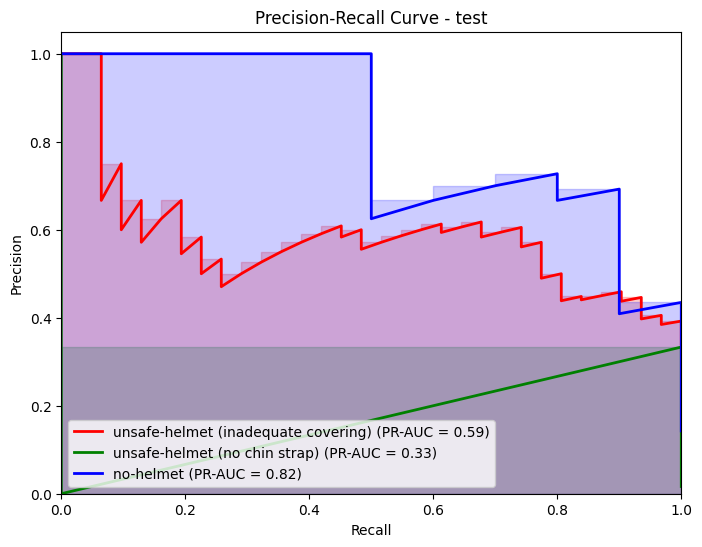

In [28]:
# PR-AUC
plt.figure(figsize=(8, 6))
for class_num, class_names in enumerate(class_category):
    if any([no_alarm_class in class_names for no_alarm_class in no_alarm_class_category]):
        continue

    use_label = [i for i in labels_np if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_prob = [j for i, j in zip(labels_np, prob_np) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
    use_prob = np.array([i[class_num] for i in use_prob])

    average_precision = average_precision_score(use_label, use_prob)
    precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
    result_precision090 = [0.9, 0, 0] # precision, recall, threshold で保存
    result_precision095 = [0.95, 0, 0] # precision, recall, threshold で保存
    for p, r, t in zip(precisions, recalls, thresholds):
        if p >= 0.9:
            result_precision090 = [p, r, t]
            break
    for p, r, t in zip(precisions, recalls, thresholds):
        if p >= 0.95:
            result_precision095 = [p, r, t]
            break

    print(f'{class_names} - PR-AUC: {average_precision:.4f}')
    print(f'precision@{result_precision090[0]:.2f} - Recall: {result_precision090[1]:.4f} - Threshold: {result_precision090[2]:.4f}')
    print(f'precision@{result_precision095[0]:.2f} - Recall: {result_precision095[1]:.4f} - Threshold: {result_precision095[2]:.4f} \n')
    if 'unsafe-helmet (inadequate covering)' in class_names:
        color = 'r'
    elif 'unsafe-helmet (no chin strap)' in class_names:
        color = 'g'
    elif 'no-helmet' in class_names:
        color = 'b'
    plt.plot(recalls, precisions, color=color, lw=2, label=f'{class_names[0]} (PR-AUC = {average_precision:.2f})')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve - test')
plt.legend(loc='best')
plt.show()

In [29]:
pd.concat([valid_all_df, test_df]).to_csv(f'{result_dir}/pred_head_class-{pattern_date}.csv', index=False)